# Autoencoders - Aula Prática

## Configurações

Importando módulos necessários

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as T

from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from math import ceil, sqrt
from tqdm.notebook import tqdm

## Introdução

Autoencoders são modelos que aprendem a representação de dados de entrada. Eles são compostos por duas partes: um encoder e um decoder. O encoder é responsável por mapear a entrada para um espaço latente, enquanto o decoder é responsável por mapear o espaço latente para a saída. A ideia é que o espaço latente seja uma representação mais compacta e significativa dos dados de entrada.

Nesta aula prática, vamos implementar um autoencoder para reconstruir imagens do dataset MNIST e entender como esse tipo de modelo funciona

## Carregando o dataset

Vamos começar carregando o dataset MNIST. O dataset é composto por imagens de dígitos escritos à mão, com dimensões 28x28 pixels.

In [2]:
mnist_path = './data/mnist'

In [ ]:
def plot_dataset(dataset, n=16, figsize=(6, 6)):
    cols = ceil(sqrt(n))
    rows = ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    for i, ax in enumerate(axes.flat):
        if i == 0:
            print(f"image shape: {dataset[i][0].shape}")
        image, _, label = dataset[i]
        ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
"""
Como queremos que o autoencoder aprenda a reconstruir a imagem de entrada,
reformulamos o dataset MNIST para que ele retorne a mesma imagem como entrada e saída.
"""
class AutoencoderMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, input_transform=None, target_transform=None, download=False, return_labels=False):
        self.dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.return_labels = return_labels

    def __getitem__(self, idx):
        x, label = self.dataset[idx]
        y = x.clone()

        if self.input_transform:
            x = self.input_transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return (x, y, label) if self.return_labels else (x, y)
    
    def start_return_labels(self):
        self.return_labels = True
    
    def stop_return_labels(self):
        self.return_labels = False

    def __len__(self):
        return len(self.dataset)

In [5]:
mnist_train_ds = AutoencoderMNIST(
    mnist_path,
    train=True,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
    download=True,
    return_labels=True
)
mnist_test_ds = AutoencoderMNIST(
    mnist_path,
    train=False,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)

Tamanho do dataset de (treino, teste): (60000, 10000)


image shape: torch.Size([1, 28, 28])


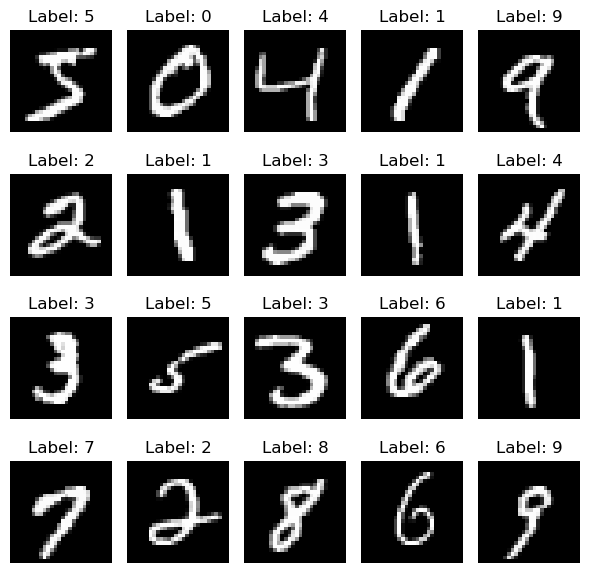

In [6]:
plot_dataset(mnist_train_ds, 20)

## Implementando o autoencoder

Vamos implementar um autoencoder convolucional simples, com 3 camadas convolucionais no encoder e 3 camadas convolucionais no decoder. A arquitetura do autoencoder é a seguinte:

- Encoder:
    - Conv2D com 16 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - MaxPooling2D com pool size 2x2
    - Conv2D com 8 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - MaxPooling2D com pool size 2x2
    - Conv2D com 2 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - Camada Linear que mapeia os features maps para o espaço latente

- Decoder:
    - Camada Linear que mapeia o espaço latente para os features maps
    - Conv2D com 128 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - UpSampling2D com size 2x2
    - Conv2D com 64 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - UpSampling2D com size 2x2
    - Conv2D com 32 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - Conv2D com 1 filtro, kernel de tamanho 3x3, função de ativação sigmoid

O tamanho do espaço latente é 2 para que possamos visualizar a representação dos dados no espaço latente.

In [7]:
class ConvolutionalEncoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(ConvolutionalEncoder, self).__init__()
        self.latent_size = latent_size

        # reduzimos o tamanho da imagem
        # considerando input (n_channels, 28, 28)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 16, 3, padding=1), # (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # (16, 14, 14)
            nn.Conv2d(16, 8, 3, padding=1), # (8, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (8, 7, 7)
            nn.Conv2d(8, 2, 3, padding=1), # (2, 7, 7)
            nn.ReLU(),
        )

        # extraimos as features da imagem reduzida
        self.flatten = nn.Flatten() # (2 * 7 * 7,) = (98,)

        # finalmente fazemos o encoding da nossa imagem em um vetor n dimensional
        self.encoder = nn.Linear(98, self.latent_size)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.encoder(x)
        return x

In [8]:
class ConvolutionalDecoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(ConvolutionalDecoder, self).__init__()
        self.latent_size = latent_size

        # decodificamos a representação latente para uma imagem 7x7
        self.decoder = nn.Linear(self.latent_size, 98)
        self.unflatten = nn.Unflatten(1, (2, 7, 7)) # (2, 7, 7)

        # voltamos a imagem ao tamanho original
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 8, 3, padding=1), # (8, 7, 7)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (8, 14, 14)
            nn.Conv2d(8, 16, 3, padding=1), # (16, 14, 14)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (16, 28, 28)
            nn.Conv2d(16, n_channels, 3, padding=1), # (n_channels, 28, 28)
            nn.Sigmoid(), # sigmoid na última camada para que o output esteja no intervalo [0, 1]
        )

    def forward(self, x):
        x = self.decoder(x)
        x = self.unflatten(x)
        x = self.conv_layers(x)
        return x

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(Autoencoder, self).__init__()
        self.encoder = ConvolutionalEncoder(latent_size, n_channels)
        self.decoder = ConvolutionalDecoder(latent_size, n_channels)

    def forward(self, x, return_latent=False):
        latent = self.encoder(x)
        x = self.decoder(latent)

        return (x, latent) if return_latent else x

In [10]:
autoencoder = Autoencoder(latent_size=2, n_channels=1)
autoencoder.cuda()
summary(autoencoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]           1,160
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
            Conv2d-7              [-1, 2, 7, 7]             146
              ReLU-8              [-1, 2, 7, 7]               0
           Flatten-9                   [-1, 98]               0
           Linear-10                    [-1, 2]             198
ConvolutionalEncoder-11                    [-1, 2]               0
           Linear-12                   [-1, 98]             294
        Unflatten-13              [-1, 2, 7, 7]               0
           Conv2d-14              [-

## Treinando o autoencoder

Vamos treinar o autoencoder para reconstruir imagens do dataset MNIST. O autoencoder será treinado por 20 épocas, com batch size 128 e otimizador Adam.

In [11]:
def train(model, optimizer, loss_fn, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            loss = loss_fn(outputs, targets)
            loss /= inputs.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss/(i+1):.4f}")

        train_loss /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)
                    loss /= inputs.size(0)

                    val_loss += loss.item()

            val_loss /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}")

In [12]:
mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

In [13]:
autoencoder = Autoencoder(latent_size=2, n_channels=1)

In [14]:
epochs = 20
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(autoencoder, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: Train Loss: 59.6947 | Val Loss: 46.3345


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: Train Loss: 44.3846 | Val Loss: 43.3033


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: Train Loss: 42.6420 | Val Loss: 42.3177


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: Train Loss: 41.8998 | Val Loss: 41.7095


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: Train Loss: 41.3703 | Val Loss: 41.1970


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: Train Loss: 40.9211 | Val Loss: 40.7057


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: Train Loss: 40.4621 | Val Loss: 40.2642


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: Train Loss: 40.0028 | Val Loss: 39.8303


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: Train Loss: 39.6895 | Val Loss: 39.4956


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: Train Loss: 39.4096 | Val Loss: 39.2190


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: Train Loss: 39.1260 | Val Loss: 39.0895


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: Train Loss: 38.8459 | Val Loss: 38.6859


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: Train Loss: 38.5586 | Val Loss: 38.3575


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: Train Loss: 38.3233 | Val Loss: 38.1560


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: Train Loss: 38.1178 | Val Loss: 38.0118


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: Train Loss: 37.9329 | Val Loss: 37.8734


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: Train Loss: 37.8036 | Val Loss: 37.7906


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: Train Loss: 37.6598 | Val Loss: 37.5351


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: Train Loss: 37.5274 | Val Loss: 37.4361


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: Train Loss: 37.4020 | Val Loss: 37.3869


## Analisando os resultados

Nessa etapa, vamos analisar os resultados obtidos pelo autoencoder. Vamos visualizar as imagens de entrada e as imagens reconstruídas pelo autoencoder. Além disso, vamos visualizar a representação dos dados no espaço latente.

In [15]:
def plot_reconstructions(model, dataset, n=8, device='cpu', figsize=(12, 6), plot_label=False):
    fig, axes = plt.subplots(3 if plot_label else 2, n, figsize=figsize)
    images = torch.cat([dataset[i][0].unsqueeze(0) for i in range(n)], dim=0).to(device)
    labels = torch.cat([dataset[i][1].unsqueeze(0) for i in range(n)], dim=0)

    model.to(device)
    model.eval()
    with torch.no_grad():
        reconstructions = model(images)

    for i, (ax, im, rec, lbl) in enumerate(zip(range(n), images, reconstructions, labels)):
        im = im.cpu().squeeze()
        rec = rec.cpu().squeeze()
        lbl = lbl.cpu().squeeze()

        if plot_label:
            axes[0][ax].imshow(lbl, cmap="gray")
            axes[0][ax].axis("off")
            axes[1][ax].imshow(im, cmap="gray")
            axes[1][ax].axis("off")
            axes[2][ax].imshow(rec, cmap="gray")
            axes[2][ax].axis("off")
        else:
            axes[0][ax].imshow(im, cmap="gray")
            axes[0][ax].axis("off")
            axes[1][ax].imshow(rec, cmap="gray")
            axes[1][ax].axis("off")

        if i == n//2:
            if plot_label:
                axes[0][ax].set_title("Original")
                axes[1][ax].set_title("Sample")
                axes[2][ax].set_title("Reconstruction")
            else:
                axes[0][ax].set_title("Sample")
                axes[1][ax].set_title("Reconstruction")

    plt.tight_layout()
    plt.show()

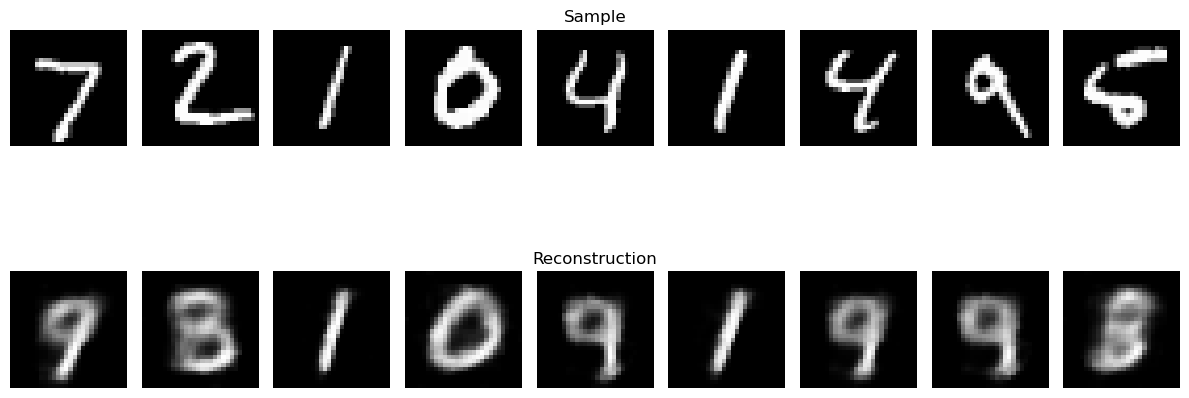

In [16]:
plot_reconstructions(autoencoder, mnist_test_ds, n=9, device=device, figsize=(12, 6))

In [17]:


def plot_latent_space(encoder, dataset, n_classes=10, batch_size=128, device='cpu', reduce_dims=None):
    # Get the latent representations for all test data
    latent_representations = []
    labels_agg = []
    classes = list(range(n_classes))

    dataset.start_return_labels()
    test_dl_with_labels = DataLoader(dataset, batch_size=batch_size)

    encoder.to(device)
    encoder.eval()
    with torch.no_grad():
        for images, _, labels in test_dl_with_labels:
            images = images.to(device)
            latent_vectors = encoder(images)
            latent_representations.append(latent_vectors.cpu().numpy())
            labels_agg.append(labels.numpy())

    # Concatenate all latent representations
    latent_representations = np.concatenate(latent_representations, axis=0)
    labels_agg = np.concatenate(labels_agg, axis=0)
    
    if reduce_dims is not None:
        if reduce_dims == 'pca':
            pca = PCA(n_components=2, random_state=42)
            latent_representations = pca.fit_transform(latent_representations)
        elif reduce_dims == 'tsne':
            tsne = TSNE(n_components=2, random_state=42)
            latent_representations = tsne.fit_transform(latent_representations)

    # Plot the latent representations
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('jet', 10)
    for c in classes:
        indices = np.where(labels_agg == c)
        plt.scatter(
            latent_representations[indices, 0],
            latent_representations[indices, 1],
            s=3,
            label=f"{c}",
            c=[cmap(c)],
            alpha=0.5,
        )
    # add the labels mapping
    plt.legend(markerscale=5)
    plt.title('Latent Representations of Test Data')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.show()

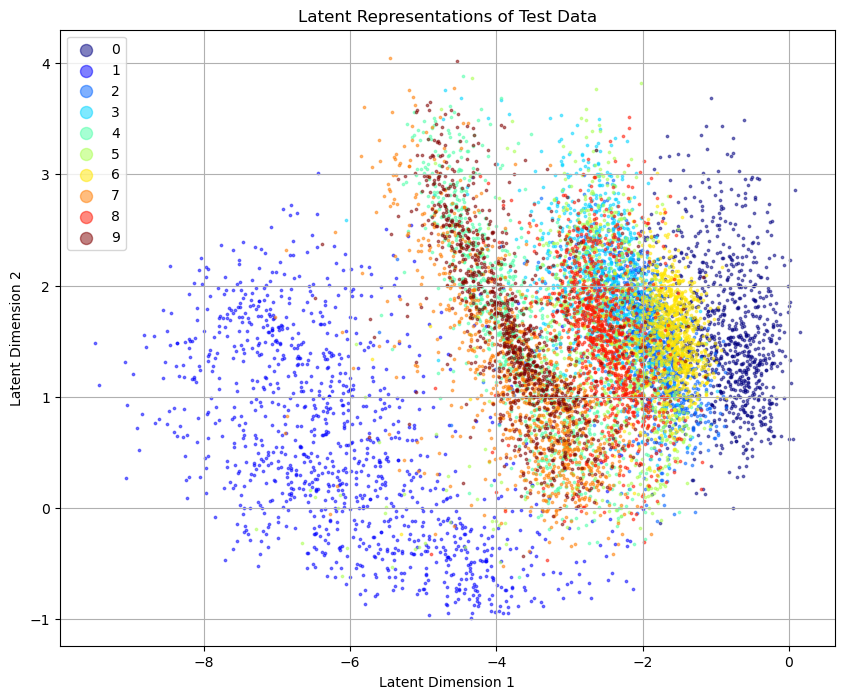

In [18]:
plot_latent_space(autoencoder.encoder, mnist_test_ds, reduce_dims=None, device=device)

Observe que os digitos estão organizados no espaço latente de acordo com suas características. Por exemplo, os digitos 0 e 1 estão distantes, enquanto os digitos 3 e 8 estão juntos. Isso mostra que o autoencoder aprendeu a representação dos dados de forma significativa.

# Exercícios

## Exercício 1 - Denoising Autoencoder

Tendo em vista que o autoencoder é capaz de aprender a representação dos dados, podemos utilizá-lo para remover ruídos das imagens. Implemente um denoising autoencoder, que recebe imagens com ruídos como entrada e tenta reconstruir a imagem original.

<details>
<summary>Dica:</summary>
Você só vai precisar de mexer no dataset de entrada, adicionando ruídos às imagens.
</details>

In [19]:
mnist_train_ds = AutoencoderMNIST(
    mnist_path,
    train=True,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
    input_transform=T.GaussianNoise(0, 0.1),
    return_labels=True,
    download=True,
)
mnist_test_ds = AutoencoderMNIST(
    mnist_path,
    train=False,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
    input_transform=T.GaussianNoise(0, 0.1)
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)

Tamanho do dataset de (treino, teste): (60000, 10000)


image shape: torch.Size([1, 28, 28])


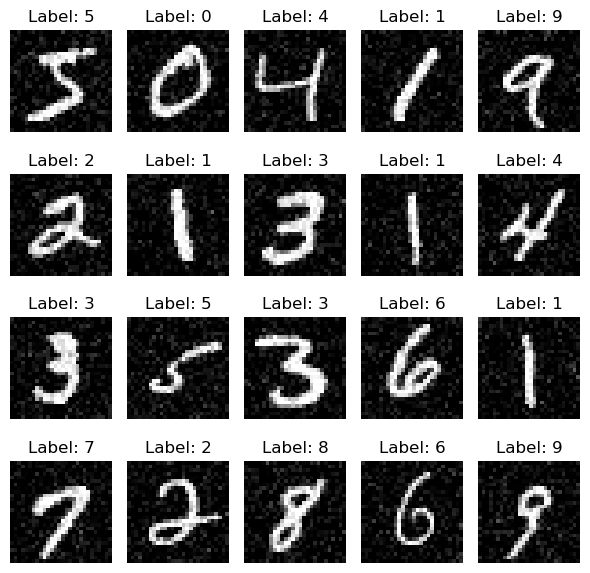

In [20]:
plot_dataset(mnist_train_ds, 20)

In [21]:
denoising_autoencoder = Autoencoder(latent_size=8, n_channels=1)

In [22]:
epochs = 20

mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(denoising_autoencoder.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(denoising_autoencoder, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: Train Loss: 92.6901 | Val Loss: 57.0171


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: Train Loss: 54.0731 | Val Loss: 52.9210


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: Train Loss: 49.6449 | Val Loss: 46.2240


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: Train Loss: 42.7299 | Val Loss: 39.6131


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: Train Loss: 37.6411 | Val Loss: 35.6264


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: Train Loss: 34.8392 | Val Loss: 33.5409


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: Train Loss: 33.2387 | Val Loss: 32.1753


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: Train Loss: 32.0876 | Val Loss: 31.1734


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: Train Loss: 31.2161 | Val Loss: 30.4128


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: Train Loss: 30.5229 | Val Loss: 29.7915


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: Train Loss: 29.9463 | Val Loss: 29.2513


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: Train Loss: 29.4612 | Val Loss: 28.8192


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: Train Loss: 29.0704 | Val Loss: 28.4563


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: Train Loss: 28.7326 | Val Loss: 28.1373


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: Train Loss: 28.4340 | Val Loss: 27.8670


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: Train Loss: 28.1640 | Val Loss: 27.6003


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: Train Loss: 27.9238 | Val Loss: 27.3756


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: Train Loss: 27.7015 | Val Loss: 27.1707


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: Train Loss: 27.4962 | Val Loss: 26.9984


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: Train Loss: 27.3151 | Val Loss: 26.8137


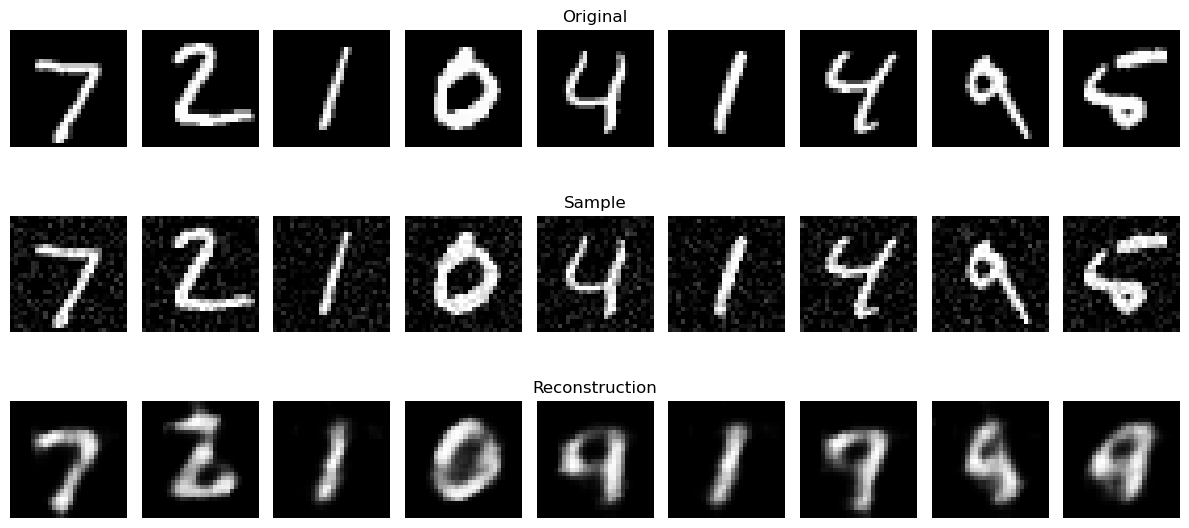

In [23]:
plot_reconstructions(denoising_autoencoder, mnist_test_ds, n=9, device=device, plot_label=True)

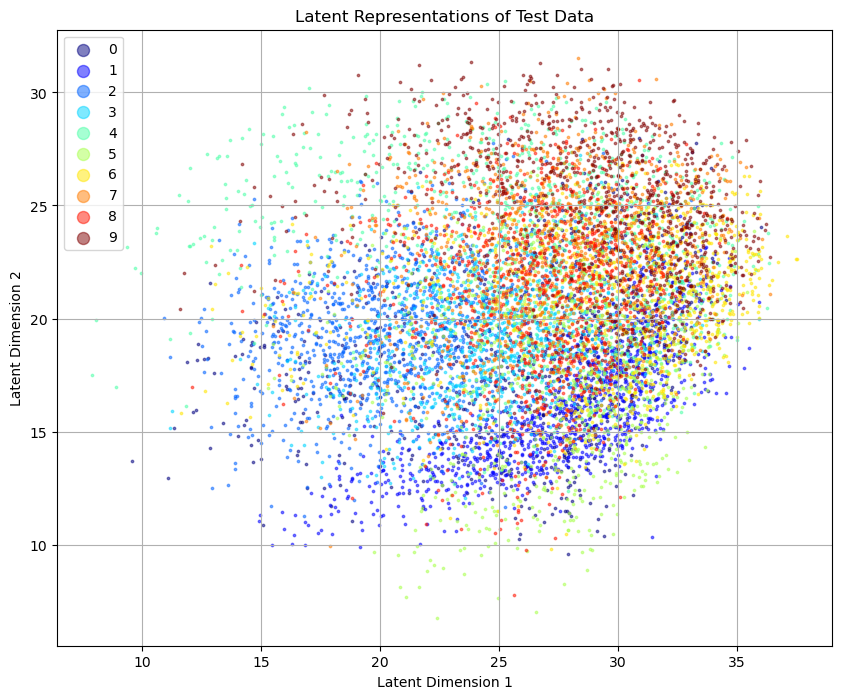

In [24]:
plot_latent_space(denoising_autoencoder.encoder, mnist_test_ds, reduce_dims=None, device=device)

## Exercício 2 - Removendo marca d'água

Implemente um autoencoder que remove a marca d'água de imagens. Para isso, adicione uma marca d'água a algumas imagens do dataset MNIST e treine o autoencoder para removê-la.

In [25]:
class Watermark(object):
    def __init__(self, watermark, clamp=True):
        self.watermark = watermark
        self.w_width, self.w_height = watermark.shape[-2:]
        self.clamp = clamp

    def __call__(self, image):
        width, height = image.shape[-2:]
        x_offset = torch.randint(0, width - self.w_width, (1,)).item()
        y_offset = torch.randint(0, height - self.w_height, (1,)).item()
        im_patch = image[..., x_offset:x_offset+self.w_width, y_offset:y_offset+self.w_height]
        im_patch += self.watermark.unsqueeze(0)
        if self.clamp:
            image = torch.clamp(image, 0, 1)
        return image

ciag_watermark = [
    [1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
]

In [26]:
mnist_train_ds = AutoencoderMNIST(
    mnist_path,
    train=True,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
    input_transform=Watermark(torch.tensor(ciag_watermark)),
    return_labels=True,
    download=True,
)
mnist_test_ds = AutoencoderMNIST(
    mnist_path,
    train=False,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
    input_transform=Watermark(torch.tensor(ciag_watermark)),
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)

Tamanho do dataset de (treino, teste): (60000, 10000)


image shape: torch.Size([1, 28, 28])


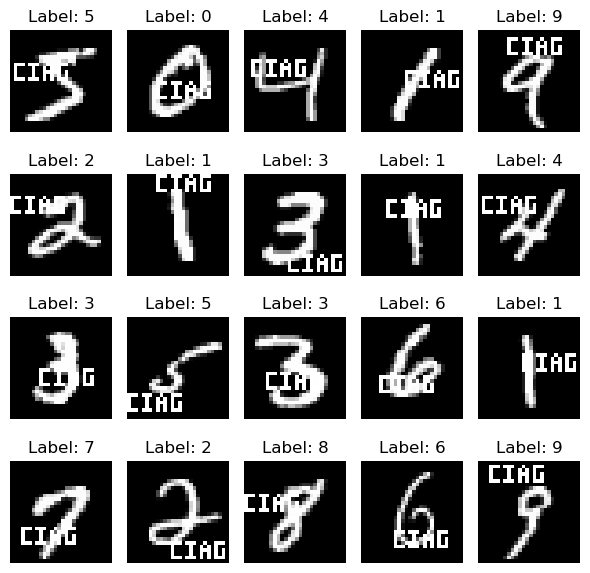

In [27]:
plot_dataset(mnist_train_ds, 20)

In [28]:
watermark_autoencoder = Autoencoder(latent_size=4, n_channels=1)

In [29]:
epochs = 20

mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(watermark_autoencoder.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(watermark_autoencoder, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: Train Loss: 95.4650 | Val Loss: 58.5826


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: Train Loss: 55.6694 | Val Loss: 54.5770


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: Train Loss: 53.8439 | Val Loss: 53.6047


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: Train Loss: 53.1777 | Val Loss: 53.1619


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: Train Loss: 52.4638 | Val Loss: 51.5347


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: Train Loss: 49.3698 | Val Loss: 47.5879


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: Train Loss: 45.7708 | Val Loss: 44.1472


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: Train Loss: 43.1598 | Val Loss: 42.2532


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: Train Loss: 41.7819 | Val Loss: 41.0951


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: Train Loss: 40.7805 | Val Loss: 40.1816


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: Train Loss: 39.9346 | Val Loss: 39.3445


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: Train Loss: 39.1787 | Val Loss: 38.6202


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: Train Loss: 38.4729 | Val Loss: 37.9314


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: Train Loss: 37.8082 | Val Loss: 37.2763


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: Train Loss: 37.1848 | Val Loss: 36.6600


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: Train Loss: 36.6193 | Val Loss: 36.1502


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: Train Loss: 36.1249 | Val Loss: 35.6859


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: Train Loss: 35.6965 | Val Loss: 35.3271


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: Train Loss: 35.3297 | Val Loss: 34.9597


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: Train Loss: 35.0028 | Val Loss: 34.6620


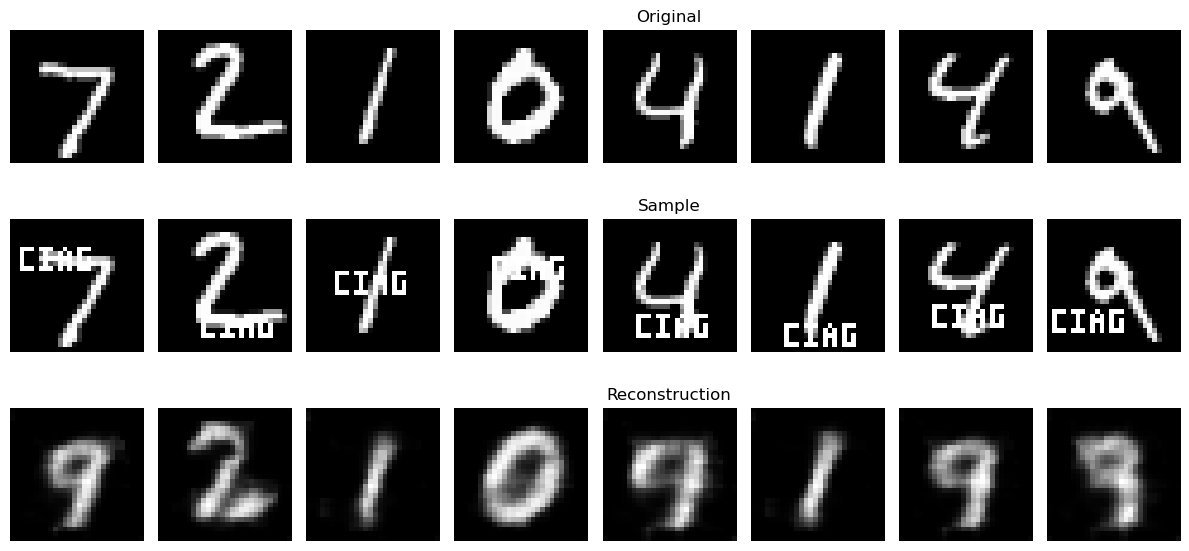

In [30]:
plot_reconstructions(watermark_autoencoder, mnist_test_ds, n=8, device=device, plot_label=True)

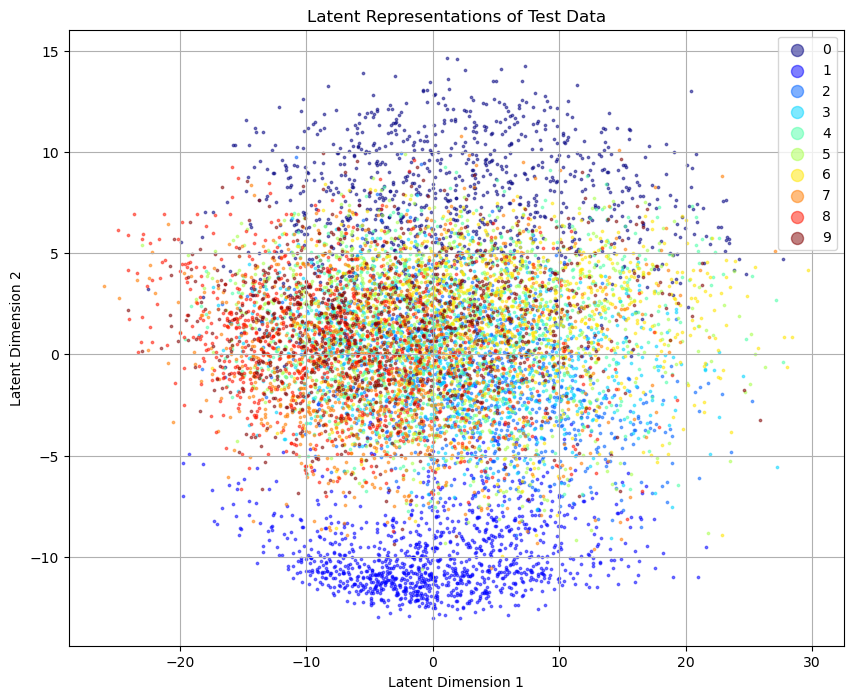

In [33]:
plot_latent_space(watermark_autoencoder.encoder, mnist_test_ds, reduce_dims='pca', device=device)

## Exercício 3 - Autoencoder com regularização

Implemente um autoencoder com regularização no espaço latente. Adicione uma regularização L1 ou L2 no espaço latente e treine o autoencoder.

<details>
<summary>Dica:</summary>
Altere a função de treino para aceitar mais um parâmetro, que será a regularização no espaço latente.
</details>

image shape: torch.Size([1, 28, 28])


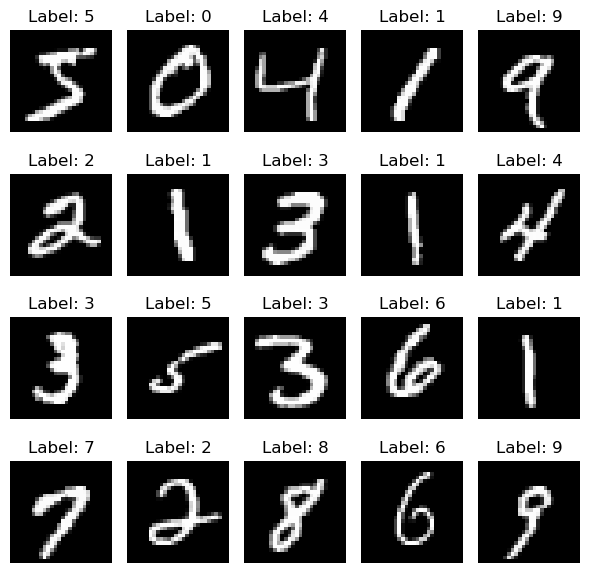

In [34]:
mnist_train_ds = AutoencoderMNIST(
    mnist_path,
    train=True,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ]),
    download=True,
    return_labels=True
)
mnist_test_ds = AutoencoderMNIST(
    mnist_path,
    train=False,
    transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])
)

plot_dataset(mnist_train_ds, 20)

In [35]:
def train_reg(model, optimizer, loss_fn, reg_loss_fn, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_reconstruction_loss = 0.0
        train_regularization_loss = 0.0

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs, latent = model(inputs, return_latent=True)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            reconstruction_loss = loss_fn(outputs, targets)
            reconstruction_loss /= inputs.size(0)
            train_reconstruction_loss += reconstruction_loss.item()

            regularization_loss = reg_loss_fn(latent)
            regularization_loss /= inputs.size(0)
            train_regularization_loss += regularization_loss.item()

            loss = reconstruction_loss + regularization_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss/(i+1):.4f}")

        train_loss /= len(train_loader)
        train_reconstruction_loss /= len(train_loader)
        train_regularization_loss /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_reconstruction_loss = 0.0
            val_regularization_loss = 0.0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs, latent = model(inputs, return_latent=True)
                    reconstruction_loss = loss_fn(outputs, targets)
                    reconstruction_loss /= inputs.size(0)
                    val_reconstruction_loss += reconstruction_loss.item()

                    regularization_loss = reg_loss_fn(latent)
                    regularization_loss /= inputs.size(0)
                    val_regularization_loss += regularization_loss.item()

                    loss = reconstruction_loss + regularization_loss

                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_reconstruction_loss /= len(val_loader)
            val_regularization_loss /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} Train Reconstruction Loss: {train_reconstruction_loss:.4f} \
Train Regularization Loss: {train_regularization_loss} | Val Loss: {val_loss:.4f} Val Reconstruction Loss: {val_reconstruction_loss:.4f} \
Val Regularization Loss: {val_regularization_loss}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} Train Reconstruction Loss: {train_reconstruction_loss:.4f} \
Train Regularization Loss: {train_regularization_loss}")

In [36]:
regularized_autoencoder = Autoencoder(latent_size=2, n_channels=1)

In [37]:
epochs = 20
lamda = 1

mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

criterion = nn.MSELoss(reduction='sum')
l2_loss = nn.MSELoss(reduction='sum')
regularization_loss = lambda x: lamda * l2_loss(x, torch.zeros_like(x))
optimizer = torch.optim.Adam(regularized_autoencoder.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_reg(regularized_autoencoder, optimizer, criterion, regularization_loss, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: Train Loss: 113.5924 Train Reconstruction Loss: 109.2713 Train Regularization Loss: 4.321154221353223 | Val Loss: 72.6237 Val Reconstruction Loss: 69.8033 Val Regularization Loss: 2.8204518209529827


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: Train Loss: 62.6253 Train Reconstruction Loss: 60.4848 Train Regularization Loss: 2.1404616535345373 | Val Loss: 57.5820 Val Reconstruction Loss: 55.8709 Val Regularization Loss: 1.7110799822626235


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: Train Loss: 54.7821 Train Reconstruction Loss: 53.3903 Train Regularization Loss: 1.3918622570759707 | Val Loss: 53.1891 Val Reconstruction Loss: 52.0838 Val Regularization Loss: 1.1053498394881622


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: Train Loss: 51.5866 Train Reconstruction Loss: 50.6542 Train Regularization Loss: 0.93236235921571 | Val Loss: 50.3736 Val Reconstruction Loss: 49.5989 Val Regularization Loss: 0.7747149475013153


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: Train Loss: 48.9966 Train Reconstruction Loss: 48.2861 Train Regularization Loss: 0.7105611429285648 | Val Loss: 47.9924 Val Reconstruction Loss: 47.3839 Val Regularization Loss: 0.6085442323473436


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: Train Loss: 47.0537 Train Reconstruction Loss: 46.4803 Train Regularization Loss: 0.5734636425844896 | Val Loss: 46.5071 Val Reconstruction Loss: 46.0066 Val Regularization Loss: 0.5004794522176815


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: Train Loss: 45.9227 Train Reconstruction Loss: 45.4584 Train Regularization Loss: 0.4643276677584089 | Val Loss: 45.6327 Val Reconstruction Loss: 45.2288 Val Regularization Loss: 0.4039349227766447


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: Train Loss: 45.2286 Train Reconstruction Loss: 44.8458 Train Regularization Loss: 0.38280430207374505 | Val Loss: 45.0593 Val Reconstruction Loss: 44.7162 Val Regularization Loss: 0.3431735219834726


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: Train Loss: 44.7355 Train Reconstruction Loss: 44.4136 Train Regularization Loss: 0.321891709876213 | Val Loss: 44.6161 Val Reconstruction Loss: 44.3344 Val Regularization Loss: 0.28165232437320903


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: Train Loss: 44.3378 Train Reconstruction Loss: 44.0647 Train Regularization Loss: 0.2731076844656137 | Val Loss: 44.2373 Val Reconstruction Loss: 43.9939 Val Regularization Loss: 0.24340426506875437


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: Train Loss: 43.9955 Train Reconstruction Loss: 43.7591 Train Regularization Loss: 0.23644667171211894 | Val Loss: 43.9151 Val Reconstruction Loss: 43.7033 Val Regularization Loss: 0.21175601088170765


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: Train Loss: 43.6922 Train Reconstruction Loss: 43.4812 Train Regularization Loss: 0.21100216010994494 | Val Loss: 43.6275 Val Reconstruction Loss: 43.4390 Val Regularization Loss: 0.18856710667097115


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: Train Loss: 43.4155 Train Reconstruction Loss: 43.2232 Train Regularization Loss: 0.1923162138093509 | Val Loss: 43.3401 Val Reconstruction Loss: 43.1651 Val Regularization Loss: 0.17492933128076263


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: Train Loss: 43.1556 Train Reconstruction Loss: 42.9783 Train Regularization Loss: 0.17731778682676205 | Val Loss: 43.0860 Val Reconstruction Loss: 42.9169 Val Regularization Loss: 0.1690783827931066


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: Train Loss: 42.8957 Train Reconstruction Loss: 42.7299 Train Regularization Loss: 0.16578510244772124 | Val Loss: 42.7998 Val Reconstruction Loss: 42.6444 Val Regularization Loss: 0.15540971946489962


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: Train Loss: 42.6297 Train Reconstruction Loss: 42.4728 Train Regularization Loss: 0.1569318987254395 | Val Loss: 42.5290 Val Reconstruction Loss: 42.3800 Val Regularization Loss: 0.1490602929003631


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: Train Loss: 42.3728 Train Reconstruction Loss: 42.2210 Train Regularization Loss: 0.15180950649956396 | Val Loss: 42.2558 Val Reconstruction Loss: 42.1123 Val Regularization Loss: 0.14354663427117503


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: Train Loss: 42.0854 Train Reconstruction Loss: 41.9371 Train Regularization Loss: 0.14832401847534343 | Val Loss: 41.8457 Val Reconstruction Loss: 41.6987 Val Regularization Loss: 0.14694415815646136


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: Train Loss: 41.6672 Train Reconstruction Loss: 41.5210 Train Regularization Loss: 0.14623551494849008 | Val Loss: 41.3799 Val Reconstruction Loss: 41.2413 Val Regularization Loss: 0.1385468449207801


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: Train Loss: 41.3909 Train Reconstruction Loss: 41.2499 Train Regularization Loss: 0.1409919356772386 | Val Loss: 41.1462 Val Reconstruction Loss: 41.0147 Val Regularization Loss: 0.1314097787194614


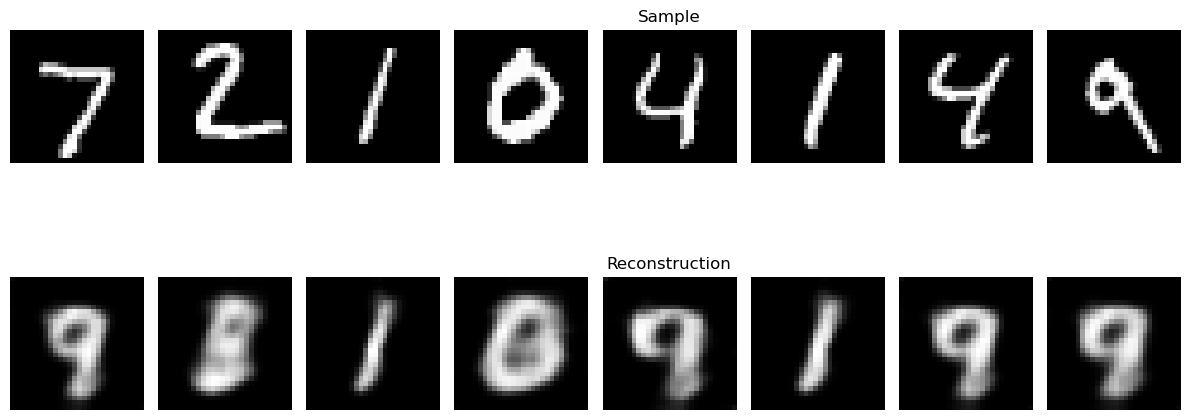

In [39]:
plot_reconstructions(regularized_autoencoder, mnist_test_ds, n=8, device=device)

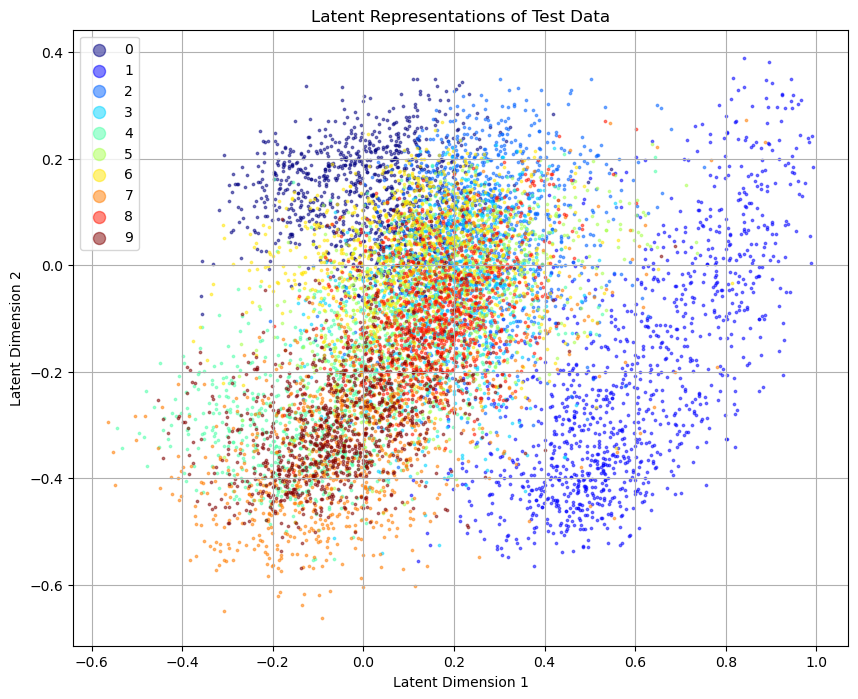

In [40]:
plot_latent_space(regularized_autoencoder.encoder, mnist_test_ds, reduce_dims=None, device=device)